<a href="https://colab.research.google.com/github/frohsch/MathSolverAI/blob/main/Idefics2_Fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tune Idefics2 on your own use-case

<p align="center">
    <img src="https://huggingface.co/HuggingFaceM4/idefics-80b/resolve/main/assets/IDEFICS.png" alt="Idefics-Obelics logo" width="300" height="300">
</p>

This tutorial showcases how one can fine-tune Idefics2 on their own use-case.

Idefics2 is an open multimodal model that accepts arbitrary sequences of image and text inputs and produces text outputs. The model can answer questions about images, describe visual content, create stories grounded on multiple images, or simply behave as a pure language model without visual inputs. It improves upon Idefics1, significantly enhancing capabilities around OCR, document understanding and visual reasoning.

Read more about Idefics2 this [blogpost](https://huggingface.co/blog/idefics2) and the [model card](https://huggingface.co/HuggingFaceM4/idefics2-8b).

# Setup

We first setup the environment with the primary necessary libraries and login into Hugging Face.

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q accelerate datasets peft bitsandbytes


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 119.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 

In [2]:
from huggingface_hub import notebook_login

notebook_login()

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Loading the model and the dataset

We load the model from the Hugging Face hub. `idefics2-8b` has gone through instruction fine-tuning on a large mixture of multimodal datasets and as such is a strong starting-point to fine-tune on your own use-case. We will start from this checkpoint.

In this tutorial, we will fine-tune (and evaluate) on the task of Document Visual Question Answering using a subset of the DocVQA dataset.

To accomodate the GPU poors, the default hyper-parameters in this tutorial are chosen so that the fine-tuning takes less than 32 GB of GPU memory. For instance, an V100 in Google Colab should be sufficient.

If you happen to have more ressources, you are encouraged to revisit some of these constraints, in particular:
- Using 4 bit quantization
- Lora fine-tuning
- Freezing the vision encoder
- Small batch size compensated with higher gradient accumulation degree
- Deactivate image splitting
- Using flash-attention

In [4]:
import torch
from peft import LoraConfig
from transformers import AutoProcessor, BitsAndBytesConfig, Idefics2ForConditionalGeneration

DEVICE = "cuda:0"
USE_LORA = False
USE_QLORA = True


processor = AutoProcessor.from_pretrained(
    "HuggingFaceM4/idefics2-8b",
    do_image_splitting=False
)


# Three options for training, from the lowest precision training to the highest precision training:
# - QLora
# - Standard Lora
# - Full fine-tuning
if USE_QLORA or USE_LORA:
    lora_config = LoraConfig(
        r=8,
        lora_alpha=8,
        lora_dropout=0.1,
        target_modules='.*(text_model|modality_projection|perceiver_resampler).*(down_proj|gate_proj|up_proj|k_proj|q_proj|v_proj|o_proj).*$',
        use_dora=False if USE_QLORA else True,
        init_lora_weights="gaussian"
    )
    if USE_QLORA:
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16
        )
    model = Idefics2ForConditionalGeneration.from_pretrained(
        "HuggingFaceM4/idefics2-8b",
        torch_dtype=torch.float16,
        quantization_config=bnb_config if USE_QLORA else None,
    )
    model.add_adapter(lora_config)
    model.enable_adapters()
else:
    model = Idefics2ForConditionalGeneration.from_pretrained(
        "HuggingFaceM4/idefics2-8b",
        torch_dtype=torch.float16,
        _attn_implementation="flash_attention_2", # Only available on A100 or H100
    ).to(DEVICE)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


processor_config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Chat templates should be in a 'chat_template.json' file but found key='chat_template' in the processor's config. Make sure to move your template to its own file.


preprocessor_config.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.64k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/92.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/74.4k [00:00<?, ?B/s]

model-00001-of-00007.safetensors:   0%|          | 0.00/4.64G [00:00<?, ?B/s]

model-00002-of-00007.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00003-of-00007.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00004-of-00007.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00005-of-00007.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00006-of-00007.safetensors:   0%|          | 0.00/4.83G [00:00<?, ?B/s]

model-00007-of-00007.safetensors:   0%|          | 0.00/4.25G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

In [5]:
from datasets import load_dataset

from datasets import DatasetDict
from datasets import load_dataset

# 데이터셋 로드
dataset = load_dataset("AI4Math/MathVerse", 'testmini')

# 데이터프레임으로 변환
dataset = dataset['testmini']

ds_train_devtest = dataset.train_test_split(test_size=0.1, seed=42)

dataset = DatasetDict({
    'train': ds_train_devtest['train'],
    'test': ds_train_devtest['test']
})

train_dataset = ds_train_devtest['train']
eval_dataset = ds_train_devtest['test']

print(dataset)


# train_dataset = load_dataset("nielsr/docvqa_1200_examples", split="train")
# train_dataset = train_dataset.remove_columns(['id', 'words', 'bounding_boxes', 'answer'])

# eval_dataset = load_dataset("nielsr/docvqa_1200_examples", split="test")
# eval_dataset = eval_dataset.remove_columns(['id', 'words', 'bounding_boxes', 'answer'])


Generating testmini split:   0%|          | 0/3940 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sample_index', 'problem_index', 'problem_version', 'question', 'image', 'answer', 'question_type', 'metadata', 'query_wo', 'query_cot', 'question_for_eval'],
        num_rows: 3546
    })
    test: Dataset({
        features: ['sample_index', 'problem_index', 'problem_version', 'question', 'image', 'answer', 'question_type', 'metadata', 'query_wo', 'query_cot', 'question_for_eval'],
        num_rows: 394
    })
})


Let's look at an example. Each sample has an image of a document, a question (in multiple languages, although we'll use the English portion only), and a list of answers.



In [6]:
train_dataset[10]

{'sample_index': '3201',
 'problem_index': '641',
 'problem_version': 'Text Dominant',
 'question': 'The figure shows a cylinder with height of 8 centimeters and radius of 6 centimeters. The volume of a cylinder is given by $V=\\pi r^2h$. \n\nFind the volume of the cylinder, rounding your answer to two decimal places.',
 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=604x387>,
 'answer': 'Volume $=904.78 \\mathrm{~cm}^{3}$',
 'question_type': 'free-form',
 'metadata': {'split': 'testmini',
  'source': 'Geo3D_collected',
  'subject': 'Solid Geometry',
  'subfield': 'Volume'},
 'query_wo': 'Please directly answer the question and provide the final value, e.g., 1, 2.5, 300.\nQuestion: The figure shows a cylinder with height of 8 centimeters and radius of 6 centimeters. The volume of a cylinder is given by $V=\\pi r^2h$. \n\nFind the volume of the cylinder, rounding your answer to two decimal places.',
 'query_cot': 'Please first conduct reasoning, and then answer the quest

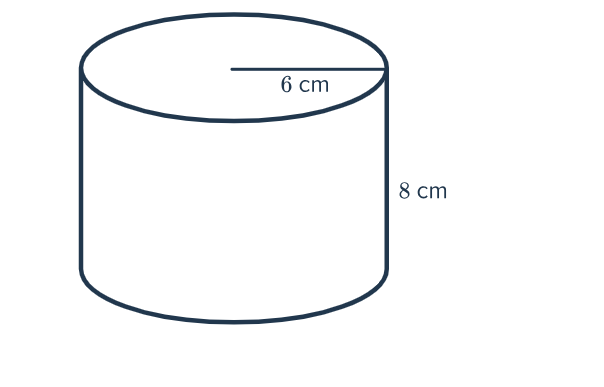

In [7]:
train_dataset[10]["image"]

# Training loop

We first define the data collator which takes list of samples and return input tensors fed to the model. There are 4 tensors types we are interested:
- `input_ids`: these are the input indices fed to the language model
- `attention_mask`: the attention mask for the `input_ids` in the language model
- `pixel_values`: the (pre-processed) pixel values that encode the image(s). Idefics2 treats images in their native resolution (up to 980) and their native aspect ratio
- `pixel_attention_mask`: when multiple image(s) are packed into the same sample (or in the batch), attention masks for the images are necessary because of these images can have different sizes and aspect ratio. This masking ensures that the vision encoder properly forwards the images.


In [11]:
import random

class MyDataCollator:
    def __init__(self, processor):
        self.processor = processor
        self.image_token_id = processor.tokenizer.additional_special_tokens_ids[
            processor.tokenizer.additional_special_tokens.index("<image>")
        ]

    def __call__(self, examples):
        texts = []
        images = []
        for example in examples:
            image = example["image"]
            question = example["query_cot"]
            answer = random.choice(example["answer"])
            messages = [
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": "Answer briefly."},
                        {"type": "image"},
                        {"type": "text", "text": question}
                    ]
                },
                {
                    "role": "assistant",
                    "content": [
                        {"type": "text", "text": answer}
                    ]
                }
            ]
            text = processor.apply_chat_template(messages, add_generation_prompt=False)
            texts.append(text.strip())
            images.append([image])

        batch = processor(text=texts, images=images, return_tensors="pt", padding=True)

        labels = batch["input_ids"].clone()
        labels[labels == processor.tokenizer.pad_token_id] = -100
        labels[labels == self.image_token_id] = -100
        batch["labels"] = labels

        return batch

data_collator = MyDataCollator(processor)


We will use HuggingFace Trainer.

In [12]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    num_train_epochs=2,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=8,
    warmup_steps=50,
    learning_rate=1e-4,
    weight_decay=0.01,
    logging_steps=25,
    output_dir="/content/drive/My Drive/docvqa_ft_tutorial",
    save_strategy="steps",
    save_steps=250,
    save_total_limit=1,
    # evaluation_strategy="epoch",
    fp16=True,
    push_to_hub_model_id="idefics2-8b-docvqa-finetuned-tutorial",
    remove_unused_columns=False,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    # eval_dataset=eval_dataset, # You can also evaluate (loss) on the eval set, note that it will incur some additional GPU memory
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:2030: FutureWarning: `--push_to_hub_model_id` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_model_id` instead and pass the full repo name to this argument (in this case ssswwwww3/idefics2-8b-docvqa-finetuned-tutorial).
  warnings.warn(


# Training and pushing to the hub

We have all the core building blocks now, so we fine-tune the model!

The training can take a few minutes depending on the hardware you use.

In [13]:
trainer.train()

Step,Training Loss
25,2.090700
50,0.536900
75,0.443000
100,0.407100
125,0.338000
150,0.288900
175,0.282200
200,0.249700
225,0.238800
250,0.164600


/usr/local/lib/python3.10/dist-packages/transformers/integrations/peft.py:397: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/integrations/peft.py:397: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


TrainOutput(global_step=442, training_loss=0.3403348323986002, metrics={'train_runtime': 2528.7351, 'train_samples_per_second': 2.805, 'train_steps_per_second': 0.175, 'total_flos': 6.32775697135465e+16, 'train_loss': 0.3403348323986002, 'epoch': 1.9943598420755781})

We push to the fine-tuned checkpoint to the hub!

In [14]:
trainer.push_to_hub()

/usr/local/lib/python3.10/dist-packages/transformers/integrations/peft.py:397: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/93.4M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ssswwwww3/idefics2-8b-docvqa-finetuned-tutorial/commit/dcb663d971cdbdbfd5776b85ab5571506e54f143', commit_message='End of training', commit_description='', oid='dcb663d971cdbdbfd5776b85ab5571506e54f143', pr_url=None, pr_revision=None, pr_num=None)

# Evaluation

Let's evaluate the model. First, we can have a look at a qualitative generation from the model.

In [15]:
example = eval_dataset[15]
example


{'sample_index': '1652',
 'problem_index': '331',
 'problem_version': 'Text Lite',
 'question': 'Consider the points on the diagram P, A and N where N denotes the north cardinal point.\n\nUsing the diagram, find the true bearing of P from A.',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=279x350>,
 'answer': '315^\\circT',
 'question_type': 'free-form',
 'metadata': {'split': 'testmini',
  'source': 'Geo2D_collected',
  'subject': 'Plane Geometry',
  'subfield': 'Angle'},
 'query_wo': 'Please directly answer the question and provide the final value, e.g., 1, 2.5, 300.\nQuestion: Consider the points on the diagram P, A and N where N denotes the north cardinal point.\n\nUsing the diagram, find the true bearing of P from A.',
 'query_cot': 'Please first conduct reasoning, and then answer the question and provide the final value, e.g., 1, 2.5, 300, at the end.\nQuestion: Consider the points on the diagram P, A and N where N denotes the north cardinal point.\n\nUsing the

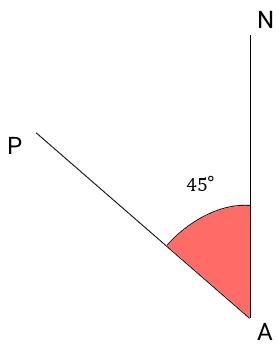

In [16]:
example["image"]

In [18]:
model.eval()

image = example["image"]
query = example["query_cot"]

messages = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "Answer briefly."},
            {"type": "image"},
            {"type": "text", "text": query}
        ]
    }
]
text = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(text=[text.strip()], images=[image], return_tensors="pt", padding=True)
generated_ids = model.generate(**inputs, max_new_tokens=64)
generated_texts = processor.batch_decode(generated_ids[:, inputs["input_ids"].size(1):], skip_special_tokens=True)
print(generated_texts)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1881: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


['1']


During the training, we tracked the loss on the evaluation split. It is interesting to measure the performance using the "true metric" used for DocVQA.

The metric at hand is the *Average Normalized Levenshtein Similarity* (ANLS). The Average Normalized Levenshtein Similarity (ANLS) proposed by [Biten+ ICCV'19](https://arxiv.org/abs/1905.13648) smoothly captures the OCR mistakes applying a slight penalization in case of correct intended responses, but badly recognized. It also makes use of a threshold of value 0.5 that dictates whether the output of the metric will be the ANLS if its value is equal or bigger than 0.5 or 0 otherwise. The key point of this threshold is to determine if the answer has been correctly selected but not properly recognized, or on the contrary, the output is a wrong text selected from the options and given as an answer.

We first define a few utilities to compute the ANLS.

In [19]:
!pip install Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 84.2 MB/s eta 0:00:00


In [20]:
import Levenshtein

def normalized_levenshtein(s1, s2):
    len_s1, len_s2 = len(s1), len(s2)
    distance = Levenshtein.distance(s1, s2)
    return distance / max(len_s1, len_s2)

def similarity_score(a_ij, o_q_i, tau=0.5):
    nl = normalized_levenshtein(a_ij, o_q_i)
    return 1 - nl if nl < tau else 0

def average_normalized_levenshtein_similarity(ground_truth, predicted_answers):
    assert len(ground_truth) == len(predicted_answers), "Length of ground_truth and predicted_answers must match."

    N = len(ground_truth)
    total_score = 0

    for i in range(N):
        a_i = ground_truth[i]
        o_q_i = predicted_answers[i]
        if o_q_i == "":
            print("Warning: Skipped an empty prediction.")
            max_score = 0
        else:
            max_score = max(similarity_score(a_ij, o_q_i) for a_ij in a_i)

        total_score += max_score

    return total_score / N


In [21]:
# Some gpu mem cleaning before inferencing eval. necessary because we are in memory constrained env
torch.cuda.empty_cache()


In [24]:
from tqdm import tqdm

EVAL_BATCH_SIZE = 1

answers_unique = []
generated_texts_unique = []

for i in tqdm(range(0, len(eval_dataset), EVAL_BATCH_SIZE)):
    examples = eval_dataset[i: i + EVAL_BATCH_SIZE]
    answers_unique.extend(examples["answer"])
    images = [[im] for im in examples["image"]]
    texts = []
    for q in examples["query_cot"]:
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": "Answer briefly."},
                    {"type": "image"},
                    {"type": "text", "text": q}
                ]
            }
        ]
        text = processor.apply_chat_template(messages, add_generation_prompt=True)
        texts.append(text.strip())
    inputs = processor(text=texts, images=images, return_tensors="pt", padding=True)
    generated_ids = model.generate(**inputs, max_new_tokens=64)
    generated_texts = processor.batch_decode(generated_ids[:, inputs["input_ids"].size(1):], skip_special_tokens=True)
    generated_texts_unique.extend(generated_texts)


100%|██████████| 394/394 [03:12<00:00,  2.04it/s]


In [25]:
generated_texts_unique = [g.strip().strip(".") for g in generated_texts_unique]
anls = average_normalized_levenshtein_similarity(
    ground_truth=answers_unique, predicted_answers=generated_texts_unique,
)
print(anls)


0.6979695431472082


We obtain an ANLS score of ~60. This is relatively low compared to well-trained models on DocVQA, although keep in mind that we are training and evaluating on a relatively small subset of the data as an exercise.

You should now have all the tools you need to fine-tuned Idefics-2 on your own dataset!